## Purpose

The purpose of this scipt is to compare our annual estimates of air quality in Pahrump, NV to the EPA's Air Quality Index (AQI). We will reuse code developed by Professor McDonald, noted throughout the notebook. His code is for use in DATA 512, a course in the UW MS Data Science degree program. This code is provided under the [Creative Commons](https://creativecommons.org) [CC-BY license](https://creativecommons.org/licenses/by/4.0/). Revision 1.1 - September 5, 2023.

We will begin by reading in python libraries and our annual smoke estimates.

In [1]:
#Imports
import json, time
import requests
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
from scipy import stats

#Reading in the annual smoke estimate
smoke_est = pd.read_csv('../clean_data/annual_smoke_estimate.csv')

Creating constants which will be referenced throughout this code. Code originally developed by Professor McDonald, edited by Emily Creeden. Update information to reflect your own email, key, etc.

In [2]:
USERNAME = <>
APIKEY = <>

#########
#
#    CONSTANTS
#

#
#    This is the root of all AQS API URLs
#
API_REQUEST_URL = 'https://aqs.epa.gov/data/api'

#
#    These are 'actions' we can ask the API to take or requests that we can make of the API
#
#    Sign-up request - generally only performed once - unless you lose your key
API_ACTION_SIGNUP = '/signup?email={email}'
#
#    List actions provide information on API parameter values that are required by some other actions/requests
API_ACTION_LIST_CLASSES = '/list/classes?email={email}&key={key}'
API_ACTION_LIST_PARAMS = '/list/parametersByClass?email={email}&key={key}&pc={pclass}'
API_ACTION_LIST_SITES = '/list/sitesByCounty?email={email}&key={key}&state={state}&county={county}'
#
#    Monitor actions are requests for monitoring stations that meet specific criteria
API_ACTION_MONITORS_COUNTY = '/monitors/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_MONITORS_BOX = '/monitors/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    Summary actions are requests for summary data. These are for daily summaries
API_ACTION_DAILY_SUMMARY_COUNTY = '/dailyData/byCounty?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&state={state}&county={county}'
API_ACTION_DAILY_SUMMARY_BOX = '/dailyData/byBox?email={email}&key={key}&param={param}&bdate={begin_date}&edate={end_date}&minlat={minlat}&maxlat={maxlat}&minlon={minlon}&maxlon={maxlon}'
#
#    It is always nice to be respectful of a free data resource.
#    We're going to observe a 100 requests per minute limit - which is fairly nice
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED
#
#
#    This is a template that covers most of the parameters for the actions we might take, from the set of actions
#    above. In the examples below, most of the time parameters can either be supplied as individual values to a
#    function - or they can be set in a copy of the template and passed in with the template.
# 
AQS_REQUEST_TEMPLATE = {
    "email":      "",     
    "key":        "",      
    "state":      "",     # the two digit state FIPS # as a string
    "county":     "",     # the three digit county FIPS # as a string
    "begin_date": "",     # the start of a time window in YYYYMMDD format
    "end_date":   "",     # the end of a time window in YYYYMMDD format, begin_date and end_date must be in the same year
    "minlat":    0.0,
    "maxlat":    0.0,
    "minlon":    0.0,
    "maxlon":    0.0,
    "param":     "",     # a list of comma separated 5 digit codes, max 5 codes requested
    "pclass":    ""      # parameter class is only used by the List calls
}

The user may need to sign up for the EPA's API - the code to do so can be uncommented below. If the use loses their key, they can sign up again using this code. Be sure to update the email value with your own email. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [3]:
'''#Request email
def request_signup(email_address = None,
                   endpoint_url = API_REQUEST_URL, 
                   endpoint_action = API_ACTION_SIGNUP, 
                   request_template = AQS_REQUEST_TEMPLATE,
                   headers = None):
    
    # Make sure we have a string - if you don't have access to this email addres, things might go badly for you
    if email_address:
        request_template['email'] = email_address        
    if not request_template['email']: 
        raise Exception("Must supply an email address to call 'request_signup()'")
    
    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

print("Requesting SIGNUP ...")
response = request_signup("ekrolen@uw.edu")
print(json.dumps(response,indent=4))'''

'#Request email\ndef request_signup(email_address = None,\n                   endpoint_url = API_REQUEST_URL, \n                   endpoint_action = API_ACTION_SIGNUP, \n                   request_template = AQS_REQUEST_TEMPLATE,\n                   headers = None):\n    \n    # Make sure we have a string - if you don\'t have access to this email addres, things might go badly for you\n    if email_address:\n        request_template[\'email\'] = email_address        \n    if not request_template[\'email\']: \n        raise Exception("Must supply an email address to call \'request_signup()\'")\n    \n    # Compose the signup url - create a request URL by combining the endpoint_url with the parameters for the request\n    request_url = endpoint_url+endpoint_action.format(**request_template)\n        \n    # make the request\n    try:\n        # Wait first, to make sure we don\'t exceed a rate limit in the situation where an exception occurs\n        # during the request processing - throt

We will need to get information about different air quality monitoring stations and the particulates they observe. We start by creating a list request. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [4]:
#
#    This implements the list request. There are several versions of the list request that only require email and key.
#    This code sets the default action/requests to list the groups or parameter class descriptors. Having those descriptors 
#    allows one to request the individual (proprietary) 5 digit codes for individual air quality measures by using the
#    param request. Some code in later cells will illustrate those requests.
#
def request_list_info(email_address = None, key = None,
                      endpoint_url = API_REQUEST_URL, 
                      endpoint_action = API_ACTION_LIST_CLASSES, 
                      request_template = AQS_REQUEST_TEMPLATE,
                      headers = None):
    
    #  Make sure we have email and key - at least
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    
    # For the basic request we need an email address and a key
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_list_info()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_list_info()'")

    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Now we need to get information on classes of sensors so we can ultimately get the sensor ID numbers for the sensors near our town. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [5]:
#
#   The default should get us a list of the various groups or classes of sensors. These classes are user defined names for clustors of
#   sensors that might be part of a package or default air quality sensing station. We need a class name to start getting down to the
#   a sensor ID. Each sensor type has an ID number. We'll eventually need those ID numbers to be able to request values that come from
#   that specific sensor.
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY

response = request_list_info(request_template=request_data)

#To see information on measurements, uncomment the below
#if response["Header"][0]['status'] == "Success":
#    print(json.dumps(response['Data'],indent=4))
#else:
#    print(json.dumps(response,indent=4))

We are looking for AQI measurements, so we should select the sensors which measure AQI. Based on the output above we will use the AQI POLLUTANTS sensor group to get sensor ids for the individual sensors. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [6]:
AQI_PARAM_CLASS = "AQI POLLUTANTS"

#
#   Structure a request to get the sensor IDs associated with the AQI
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['pclass'] = AQI_PARAM_CLASS  # here we specify that we want this 'pclass' or parameter classs

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_PARAMS)

#To see individual pollutants and their codes, uncomment the below
#if response["Header"][0]['status'] == "Success":
#    print(json.dumps(response['Data'],indent=4))
#else:
#    print(json.dumps(response,indent=4))

Using the above output we can see what sensor codes correspond to each element of AQI. There are gases and particulates both included in AQI measurements, and their codes are listed below. We need to break up the two kinds of sensors due to API restrictions on how many codes can be included in the pull. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [7]:
#
#   Given the set of sensor codes, now we can create a parameter list or 'param' value as defined by the AQS API spec.
#   It turns out that we want all of these measures for AQI, but we need to have two different param constants to get
#   all seven of the code types. We can only have a max of 5 sensors/values request per param.
#
#   Gaseous AQI pollutants CO, SO2, NO2, and O2
AQI_PARAMS_GASEOUS = "42101,42401,42602,44201"
#
#   Particulate AQI pollutants PM10, PM2.5, and Acceptable PM2.5
AQI_PARAMS_PARTICULATES = "81102,88101,88502"
#   
#

We will be looking for AQI sensors near Pahrump. We include the town's information below for future calls. Code originally developed by Professor McDonald, edited by Emily Creeden.

In [8]:
#Saving Pahrump information
CITY_LOCATIONS = {
    'pahrump' :       {'city'   : 'Pahrump',
                       'county' : 'Nye',
                       'state'  : 'Nevada',
                       'fips'   : '32023', #Combination of state (32) and county (023) FIPS codes
                       'latlon' : [36.231143, -116.017339]}, 
}

We will now return all the EPA monitoring sites within Nye County (the county containing Pahrump, NV). Code originally developed by Professor McDonald, edited by Emily Creeden.

In [9]:
#
#  This list request should give us a list of all the monitoring stations in the county specified by the
#  given city selected from the CITY_LOCATIONS dictionary
#
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['pahrump']['fips'][:2]   # the first two digits (characters) of FIPS is the state code
request_data['county'] = CITY_LOCATIONS['pahrump']['fips'][2:]  # the last three digits (characters) of FIPS is the county code

response = request_list_info(request_template=request_data, endpoint_action=API_ACTION_LIST_SITES)

#To see the individual sensor codes and locations, uncomment the below
#if response["Header"][0]['status'] == "Success":
#    print(json.dumps(response['Data'],indent=4))
#else:
#    print(json.dumps(response,indent=4))

We now need to get outputs from the local AQI stations. For this we pull daily summary requests. Per Professor McDonald's note, "The function below is designed to encapsulate requests to the EPA AQS API. When calling the function one should create/copy a parameter template, then initialize that template with values that won't change with each call. Then on each call simply pass in the parameters that need to change, like date ranges." Code originally developed by Professor McDonald, edited by Emily Creeden.

In [10]:
#
#    This implements the daily summary request. Daily summary provides a daily summary value for each sensor being requested
#    from the start date to the end date. 
#
#    Like the two other functions, this can be called with a mixture of a defined parameter dictionary, or with function
#    parameters. If function parameters are provided, those take precedence over any parameters from the request template.
#
def request_daily_summary(email_address = None, key = None, param=None,
                          begin_date = None, end_date = None, fips = None,
                          endpoint_url = API_REQUEST_URL, 
                          endpoint_action = API_ACTION_DAILY_SUMMARY_COUNTY, 
                          request_template = AQS_REQUEST_TEMPLATE,
                          headers = None):
    
    #  This prioritizes the info from the call parameters - not what's already in the template
    if email_address:
        request_template['email'] = email_address
    if key:
        request_template['key'] = key
    if param:
        request_template['param'] = param
    if begin_date:
        request_template['begin_date'] = begin_date
    if end_date:
        request_template['end_date'] = end_date
    if fips and len(fips)==5:
        request_template['state'] = fips[:2]
        request_template['county'] = fips[2:]            

    # Make sure there are values that allow us to make a call - these are always required
    if not request_template['email']:
        raise Exception("Must supply an email address to call 'request_daily_summary()'")
    if not request_template['key']: 
        raise Exception("Must supply a key to call 'request_daily_summary()'")
    if not request_template['param']: 
        raise Exception("Must supply param values to call 'request_daily_summary()'")
    if not request_template['begin_date']: 
        raise Exception("Must supply a begin_date to call 'request_daily_summary()'")
    if not request_template['end_date']: 
        raise Exception("Must supply an end_date to call 'request_daily_summary()'")
    # Note we're not validating FIPS fields because not all of the daily summary actions require the FIPS numbers
        
    # compose the request
    request_url = endpoint_url+endpoint_action.format(**request_template)
        
    # make the request
    try:
        # Wait first, to make sure we don't exceed a rate limit in the situation where an exception occurs
        # during the request processing - throttling is always a good practice with a free data source
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

The below code sets up the parameters and constants necessary to extract the summary sensor data.

In [11]:
#Setting up requests to the EPA's APIs
request_data = AQS_REQUEST_TEMPLATE.copy()
request_data['email'] = USERNAME
request_data['key'] = APIKEY
request_data['state'] = CITY_LOCATIONS['pahrump']['fips'][:2]
request_data['county'] = CITY_LOCATIONS['pahrump']['fips'][2:]

The below code returns daily summaries for AQI elements collected from local sensors near Pahrump, NV. We will only be collecting data during fire season given we are going to compare it with wildland fire smoke estimates and most fires occurr during fire season (May 1st-Oct 31st). Additionally, while some stations may produce granular AQI measurements (e.g., on the hourly scale), "The Air Quality Index is based on daily air quality summaries, specifically daily maximums or daily
averages. It is not valid to use shorter-term (e.g. hourly) data to calculate an AQI value." [Technical Assistance Document for the Reporting of Daily Air Quality – the Air Quality Index (AQI)](https://www.airnow.gov/sites/default/files/2020-05/aqi-technical-assistance-document-sept2018.pdf) Due to this standard, we will only use the 24-HR BLK AVG AQI measurement for each gas/particulate.

In [12]:
#Making the list of years
year_list = []
for value in range(1963, 2024):
    year_list.append(value)

AQI_df = pd.DataFrame(columns = ['site_number', 'parameter_code', 'sample_duration','date_local','aqi'])
#Querying the API repeatedly
for year in year_list:
    if (1963-year) % 5 == 0 or year == 1963:
        print("Processing AQI data for {0}...".format(year))
    start_date = str(year)+'0501'
    terminate_date = str(year)+'1031'
    #Getting gaseous information
    request_data['param'] = AQI_PARAMS_GASEOUS
    gaseous_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=terminate_date)
    if gaseous_aqi["Header"][0]['status'] == "Success":
        for datum in gaseous_aqi['Data']:
            if datum['sample_duration'] == '24-HR BLK AVG':
                    AQI_df = df.append({'site_number':datum['site_number'],
                                        'parameter_code':datum['parameter_code'],
                                        'sample_duration':datum['sample_duration'],
                                        'date_local':datum['date_local'],
                                        'aqi':datum['aqi']
                                        }, ignore_index = True)
            else: pass
    else: pass
    #Getting particulate information
    request_data['param'] = AQI_PARAMS_PARTICULATES
    particulate_aqi = request_daily_summary(request_template=request_data, begin_date=start_date, end_date=terminate_date)
    if particulate_aqi["Header"][0]['status'] == "Success":
        for datum in particulate_aqi['Data']:
            if datum['sample_duration'] == '24-HR BLK AVG':
                AQI_df = AQI_df.append({'site_number':datum['site_number'],
                                    'parameter_code':datum['parameter_code'],
                                    'sample_duration':datum['sample_duration'],
                                    'date_local':datum['date_local'],
                                    'aqi':datum['aqi']
                                    }, ignore_index = True)
            else: pass
    else: pass
    #Save intermediate outputs
    if (1963-year) % 20 == 0:
        AQI_df.to_csv("../intermediate_data/unaggregated_aqi.csv", index = None)

#Save final DF to file
AQI_df.to_csv("../intermediate_data/unaggregated_aqi.csv", index = None)

Processing AQI data for 1963...
Processing AQI data for 1968...
Processing AQI data for 1973...
Processing AQI data for 1978...
Processing AQI data for 1983...
Processing AQI data for 1988...
Processing AQI data for 1993...
Processing AQI data for 1998...
Processing AQI data for 2003...
Processing AQI data for 2008...
Processing AQI data for 2013...
Processing AQI data for 2018...
Processing AQI data for 2023...


Now we will examine the AQI data pulled from sensors in and around Pahrump, NV. We can see that some sensors do not collect any data (e.g., sensors 0001, 0002, 0003, 0004), and our local sensors only collect information on particulate matter with a diameter of 10 microns or less (PM10 Total 0-10um STP, code 81102).

In [13]:
print(AQI_df.head())
print("The stations which return AQI information are: {0}".format(AQI_df['site_number'].unique()))
print("The pollutants returned are: {0}".format(AQI_df['parameter_code'].unique()))

  site_number parameter_code sample_duration  date_local aqi
0        0010          81102   24-HR BLK AVG  2004-05-01  32
1        0010          81102   24-HR BLK AVG  2004-05-02  28
2        0010          81102   24-HR BLK AVG  2004-05-03  40
3        0010          81102   24-HR BLK AVG  2004-05-04  49
4        0010          81102   24-HR BLK AVG  2004-05-05  52
The stations which return AQI information are: ['0010' '0011' '0012' '0013' '0014' '0015']
The pollutants returned are: ['81102']


Because local stations in Nye County only pull one type of particulate matter, there is no need to find the max particulate AQI per station as is typical with AQI calculations. Instead, we will move on to create a yearly AQI average for stations within Nye county. We will average over all stations per day per year. We do not take the average of the daily max AQI for all stations because we want to get a sense of the air quality of Pahrump on average.

In [14]:
#Read in the AQI df in the event that the programmer took a break
AQI_df = pd.read_csv('../intermediate_data/unaggregated_aqi.csv')

#Adding year col to the df
AQI_df['year'] = AQI_df['date_local'].str[:4]

#Grouping by year and averaging the AQI
yearly_avg_AQI = AQI_df.groupby('year')['aqi'].mean().to_frame('annual_avg_aqi').reset_index()

#Saving annual avg AQI
yearly_avg_AQI.to_csv('../clean_data/yearly_avg_aqi.csv', index = None)

Now we will compare our smoke estimates to the annual AQI estimates. To ensure we are comparing like for like we will normalize the data and plot a linear regression noting the correlation via "r". The linear regression code was modified from [W3 Schools](https://www.w3schools.com/python/python_ml_linear_regression.asp).

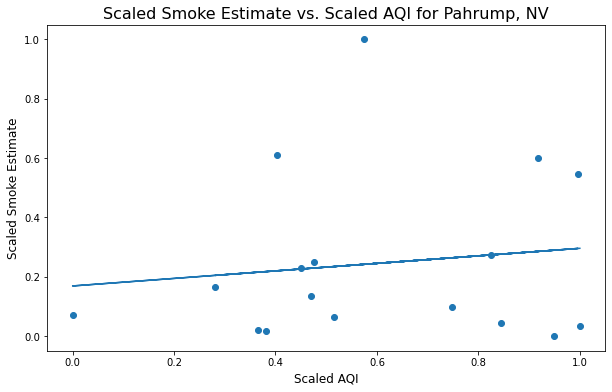

The r-squared value for the linear regression is 0.13.


In [15]:
#Loading in the smoke estimates and AQI data
smoke_est = pd.read_csv('../clean_data/annual_smoke_estimate.csv')
aqi_est = pd.read_csv('../clean_data/yearly_avg_aqi.csv')

#Inner joining the datasets
smoke_aqi = pd.merge(left = smoke_est, right = aqi_est, how = "inner", left_on = 'Fire_Year', right_on = 'year')
smoke_aqi.head()

#Normalizing the columns
df_min_max_scaled = smoke_aqi.copy() 
df_min_max_scaled['scaled_smoke'] = (df_min_max_scaled['Annual_Smoke_Estimate'] - df_min_max_scaled['Annual_Smoke_Estimate'].min()) / (df_min_max_scaled['Annual_Smoke_Estimate'].max() - df_min_max_scaled['Annual_Smoke_Estimate'].min())     
df_min_max_scaled['scaled_aqi'] = (df_min_max_scaled['annual_avg_aqi'] - df_min_max_scaled['annual_avg_aqi'].min()) / (df_min_max_scaled['annual_avg_aqi'].max() - df_min_max_scaled['annual_avg_aqi'].min())     

#Graphing the two columns to see the relationship
x = df_min_max_scaled['scaled_aqi']
y = df_min_max_scaled['scaled_smoke']

slope, intercept, r, p, std_err = stats.linregress(x, y)

def line_eqn(x):
  return slope * x + intercept

mymodel = list(map(line_eqn, x))

plt.figure(figsize=(10,6))
plt.scatter(x, y)
plt.plot(x, mymodel)
plt.xlabel('Scaled AQI', size=12)
plt.ylabel('Scaled Smoke Estimate', size=12)
plt.title('Scaled Smoke Estimate vs. Scaled AQI for Pahrump, NV', size=16)
plt.show()

print("The r-squared value for the linear regression is {0}.".format(round(r,2)))

From the above calculation we can see that our smoke estimators and AQI estimators are positively correlated, but the coefficient of correlation isn't very strong, only 0.13. Ideally we would have a correlation in the 0.7 to 1.0 range to indicate strong alignment. However, we should remember that our smoke estimate is relatively simplistic and misses important factors such as weather, fire fuel, topography, etc. Additionally, our EPA monitoring stations only track data for one particulate, rather than a combination of particulate and gaseous factors, limiting our overall AQI metric. In summary, we are pleased to see a positive correlation, but do wish the strength of correlation was higher. If given more time, it would be interesting to tweak the smoke estimates (e.g., alter the formula, consider only certain kinds of fires) and AQI measurements (e.g., find additional monitoring stations, calculate the max AQI vs. average AQI) to see if we could get stronger correlation.